In [1]:
import numpy as np
import cv2 # opencv for image processing
import datetime # timestamp for file saving
import pandas as pd # for CSV processing and data frame creation
from scipy.stats import ks_2samp # for KS 2-sample test
from sklearn.cluster import KMeans # for kmeans clustering
import matplotlib.pyplot as plt #lighter weight for plotting in jupyter notebook than opencv
import glob # for formatting file names
from collections import Counter

# Objective: Segment vasculature in ophthalmic images in RGB space

### Executing the code:
<li> This code is intended for execution in a jupyter notebook with the kernel set to the python virtual environment created for this project.
<li> Please see requirements.txt for the required package installations used for this project.

### Assumptions
<li> Every raw image has a corresponding Grader1 and Grader2 segmentation
<li> The same naming convention applies to all images in the three folders (Raw images, Grader1, and Grader2), namely "im####.[extension]".
<li> The "ah" in "ah.ppm" and "vk" in "vk.ppm" are initials of the human Graders and not different file types.
<li> The segmentations of each image contain only black [0, 0, 0] and white [255, 255, 255] in RGB space, which becomes [0,255] when converted to grayscale.
<li> The images were all collected on the same device by the same individual.

# Set your homedir in which the image folders are locate

## The following folders are expected:
1. [homedir]/Data/Grader1
2. [homedir]/Data/Grader2
3. [homedir]/Data/Raw images


In [13]:
# SETTING THE HOMEDIR
homedir = '~/Aim2/'
datadir = homedir+'Data/'
savedir = homedir+'Results/'
codedir = homedir+'Code/'

## Creation of the functions that will be used in the analysis

In [3]:
# CREATE FUNCTIONS

# PURPOSE: Load images with specified extension from a given folder
def load_images_from_folder(folder, extension, saveImInfo=True, colmap='RGB'):
    # INPUTS:
    # - folder: folder from which you want to read the images
    # - extension: file extension of the desired images
    # - saveImInfo: to save or not to save the CSV of information for the loaded images
    # OUTPUT: list of images as imlist
    
    imlist = [] # list in which images will be stored
    iminfo = {"filename":[],"Data Type":[],"Shape":[]} #dictionary of image information
    for filename in sorted(glob.glob(f'{folder}/*{extension}')):
        # load the image from file with opencv
        img = cv2.imread(filename)
        #opencv loads RGB images as BGR, so let's convert to the standard RGB
        if colmap=='RGB':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif colmap=='GRAY':
            img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        #we only want to add non-empty images to our list
        if img is not None:
            imlist.append(img)
            # let's store the filename, data type, and shape of each image for reference
            iminfo["filename"].append(filename)
            iminfo["Data Type"].append(img.dtype)
            iminfo["Shape"].append(img.shape)
        else:
            print("File {} is empty!".format(filename))
    
    # convert the dictionary to a dataframe, using timestamp in the filename to prevent accidental overwriting
    iminfo_df = pd.DataFrame.from_dict(iminfo)
    if saveImInfo:
        iminfo_df.to_csv(f"{folder}/iminfo_{datetime.datetime.now().timestamp()}.csv")
    
    # return the list of loaded images, imlist, and the iminfo dataframe
    print("Returning list of images of length ", len(imlist))
    return imlist, iminfo_df

# PURPOSE: Plot all the images as different subplots for a quick visual check
def plot_images_from_list(imlist,nrow,ncol):
    # INPUTS:
    # - imlist: the list of image arrays you want to visualize in the subplot
    # - nrow: number of rows in the subplot
    # - ncol: number of columns in the subplot
    
    _, axs = plt.subplots(nrow, ncol, figsize=(12, 12)) #establish axes for the subplots arranged as nrow x ncol
    axs = axs.flatten() # linearize the axis object
    for img, ax in zip(imlist, axs): #pair an axis object in axs with each image in imlist
        if len(img.shape)>2:
            ax.imshow(img) 
            ax.set_xticklabels([])
            ax.set_yticklabels([])

        else:
            ax.imshow(img,cmap='gray')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

# PURPOSE: Compute the KS 2 sample test to compare the distributions of RGB values in the vasculature and 
# background. Optionally, plot overlaid histograms of the segmented vasculature and the background.
def compute_kstest_img_seg(img,seg,visImages=True):
    # INPUTS:
    # - img: RGB retinal image
    # - seg: segmentation of vasculature as RGB black and white image
    # - visImages: Turn on/off visualization of images for visual checks
    # OUTPUT: p-values and test statistics from KS 2-sample test
    seg_vasc = seg
    if np.max(seg_vasc)>1:
        seg_vasc = seg_vasc//255

    # Create background segmentation from seg_vasc (swap the 0s and 1s in a new array)
    seg_bg = np.zeros(seg_vasc.shape,dtype='uint8')
    seg_bg[seg_vasc==0]=1
    
    vasc = img*seg_vasc # apply seg_vasc to the raw image and isolate the vasculature
    bg = img*seg_bg # apply seg_bg to the raw image and isolate the background
    vasc_vec = vasc[seg_vasc==1].ravel() #exclude any non-vasculature pixels
    bg_vec = bg[seg_bg==1].ravel() #exclude any non-background pixels
    # Visualize the raw images with the vasculature and background masks applied, respectively
    if visImages:
        _,axs=plt.subplots(1,3,figsize=(15,15))
        axs = axs.flatten()
        axs[0].imshow(vasc,cmap='gray')
        axs[0].set_title("Vasculature",fontsize=30)
        axs[1].imshow(bg,cmap='gray')
        axs[1].set_title("Background",fontsize=30)
        axs[2].imshow(img,cmap='gray')
        axs[2].set_title("Raw Image",fontsize=30)
        
        plt.show()

        plt.hist(vasc_vec,density=True,label="vasculature",alpha=0.5)
        plt.hist(bg_vec,density=True,label="background",alpha=0.9, histtype='step')
        plt.xlim([0,255])
        plt.legend(loc='upper right')
        plt.title('Histogram of RGB distributions')
        plt.show()

    pval = [] # store pvalues from KS 2 sample test
    stat = [] # store test statistics from KS 2 sample test 
    # Use the Kolmogorov-Smirnov 2-sample test to see if the background vs. vasculature disributions differ
    out = ks_2samp(bg_vec,vasc_vec)
    stat.append(out[0])
    pval.append(out[1])

    
    return [stat,pval] # stat and pval each have length 3 (one value per color channel)
    
# PURPOSE: Compute the DICE score to compare a guess segmentation with the ground truth segmentation
def compute_DICE_score(gt_seg,guess):
    # INPUTS:
    # - gt_seg: ground truth segmentation (sourced from Grader1 and Grader2, separately)
    # - guess: segmentation outputted from the proposed algorithm
    # - clust: cluster assignment of interest that corresponds to vasculature
    
    # make sure the masks are not still scaled [0,255]
    if np.max(guess)>1:
        guess = guess//255
    if np.max(gt_seg)>1:
        gt_seg = gt_seg//255
    dice = np.sum(guess[gt_seg==1])*2 / (np.sum(guess) + np.sum(gt_seg))
    return dice

# PURPOSE: Given a list of gray scale ophthalmic images, apply image transformations to segment 
# the vasculature and return a list of corresponding segmentations!
def segment_vasculature(imlist,thresh):
    # INPUTS:
    # - imlist: list of raw images to segment
    # - thresh: scalar value for thresholding for creating a mask that selects the circular retina from the 
    # the dark background. This will be decided on through visual inspection of the final results 
    
    seg_list = []
    for idx,img in enumerate(imlist):
        #apply thresholding to obtain a mask for the retina as the region of interest
        seg_retina=np.zeros((605,700))
        seg_retina[img>thresh]=1
        
        # Apply a Gaussian filter to denoise the image
        im_blur = cv2.GaussianBlur(img, (0,0), sigmaX=15, sigmaY=15)

        # Divide the img by the blurred image
        im_div = cv2.divide(img, im_blur, scale=255)

        # Apply adaptive thresholding using a Gaussian-weighted sum of the neighborhood of pixels 
        # to locally threshold the image
        im_thresh =  cv2.adaptiveThreshold(im_div,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,21,2)

        # Using a rectangular structuring element, apply erosion + dilation for local denoising
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        im_morph = cv2.morphologyEx(im_thresh, cv2.MORPH_CLOSE, kernel)

        #plt.imshow(morph,cmap='gray')
        #plt.colorbar()

        seg_i = np.zeros((605,700))
        seg_i[im_morph==0]=1 # we want the vasculature to be 1 and background to be 0
        seg_final_i = seg_i*seg_retina
        seg_list.append(seg_final_i) #only consider segmentations within the retina
        
        
    return seg_list


        

## Exploratory analysis of the data: visualization and preliminary statistics

In [4]:
# LOAD RAW IMAGES AND GRADERS' SEGMENTATIONS


# define the file paths for the raw images, Grader1, and Grader2, respectively
imfolder = datadir+'Raw images'
seg1folder = datadir+'Grader1'
seg2folder = datadir+'Grader2'

# load the list of raw images, Grader1 segmentations, and Grader2 segmentations, respectively
# Once we've saved the CSV files with image information once, we can set saveImInfo=False
imlist,iminfo = load_images_from_folder(imfolder,'.ppm',saveImInfo=False,colmap='RGB')
imlist_gray,_= load_images_from_folder(imfolder,'.ppm',saveImInfo=False,colmap='GRAY')
seg1, seg1info = load_images_from_folder(seg1folder,'.ah.ppm',saveImInfo=False,colmap='GRAY')
seg2, seg2info = load_images_from_folder(seg2folder,'.vk.ppm',saveImInfo=False,colmap='GRAY')


Returning list of images of length  20
Returning list of images of length  20
Returning list of images of length  20
Returning list of images of length  20


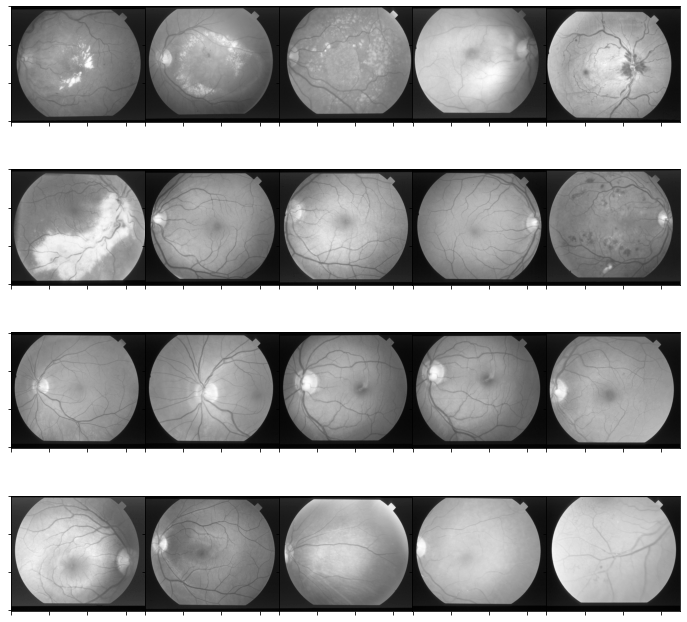

In [5]:
# PLOT THE IMAGES TO VISUALLY CHECK THAT THEY'RE LOADING PROPERLY

imtoplot= imlist_gray #set to either "imlist","imlist_gray",seg1", or "seg2"
plot_images_from_list(imtoplot,nrow=4,ncol=5)


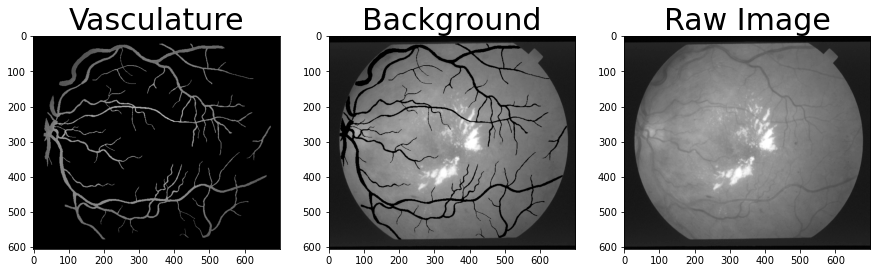

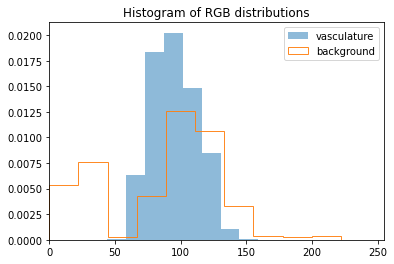

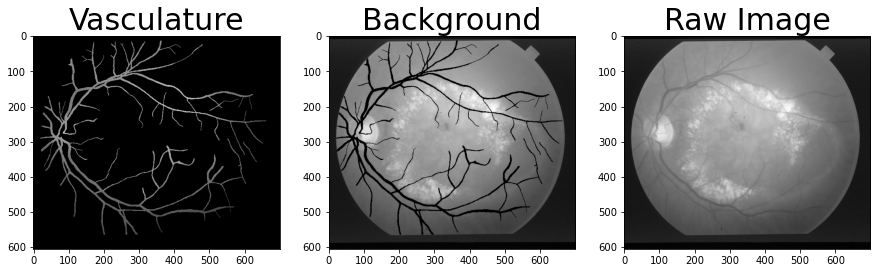

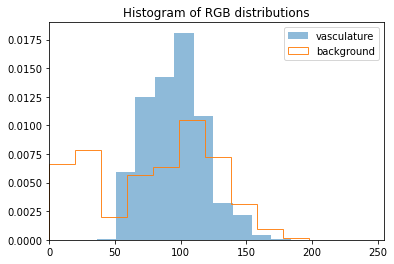

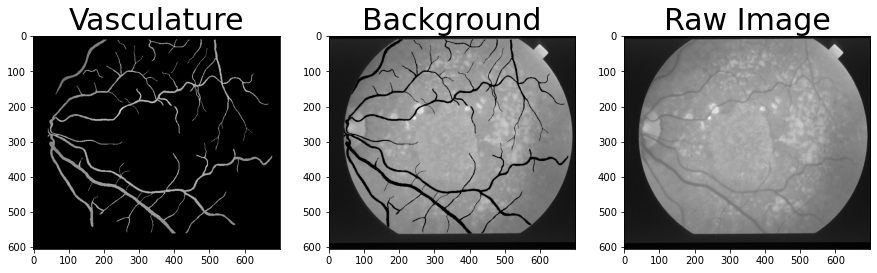

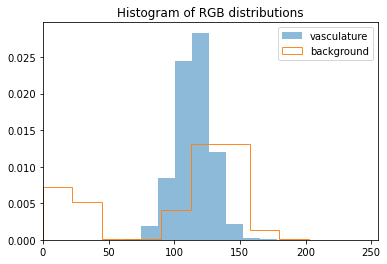

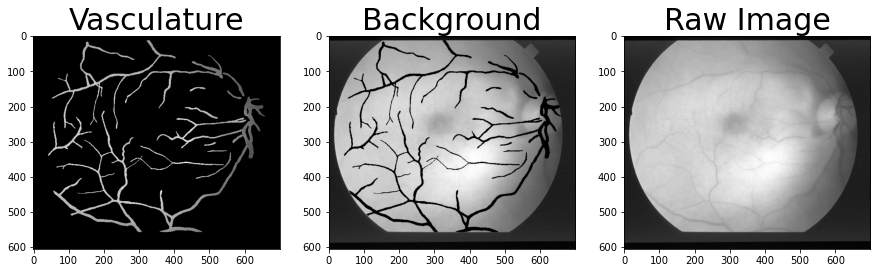

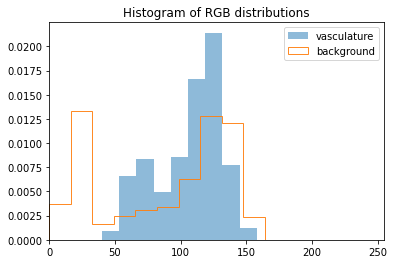

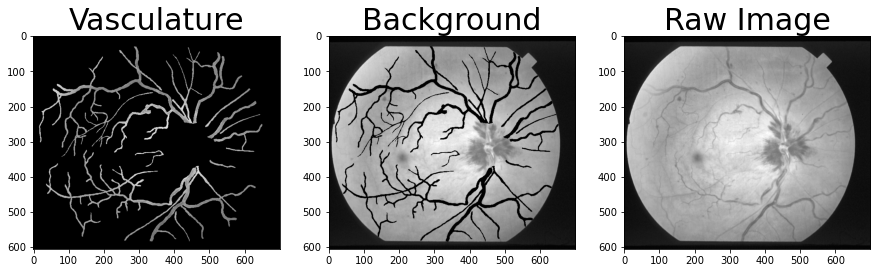

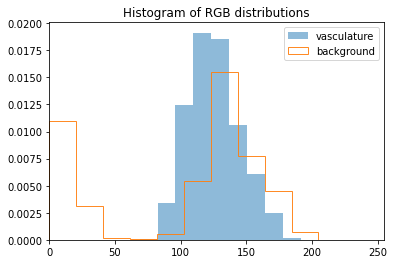

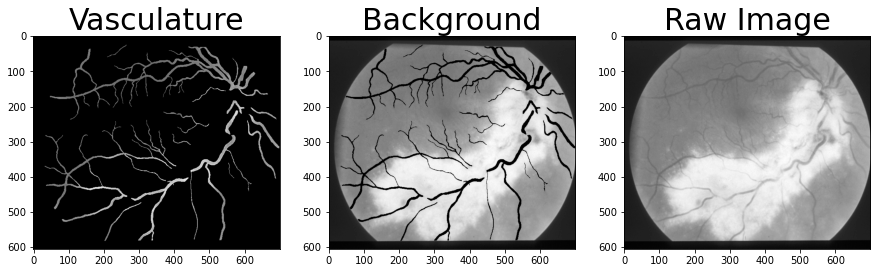

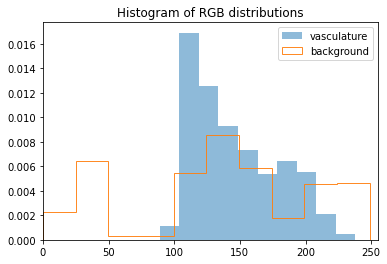

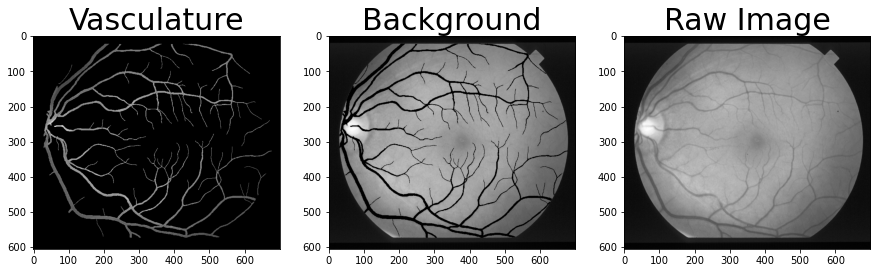

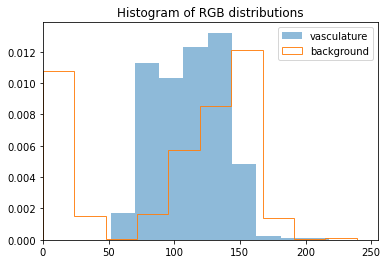

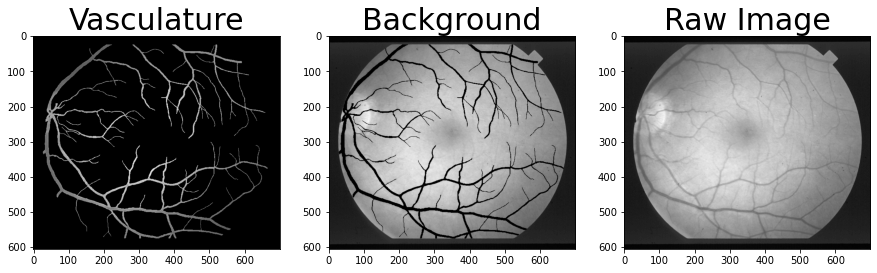

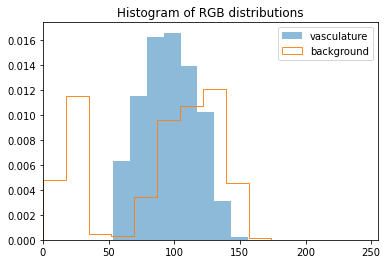

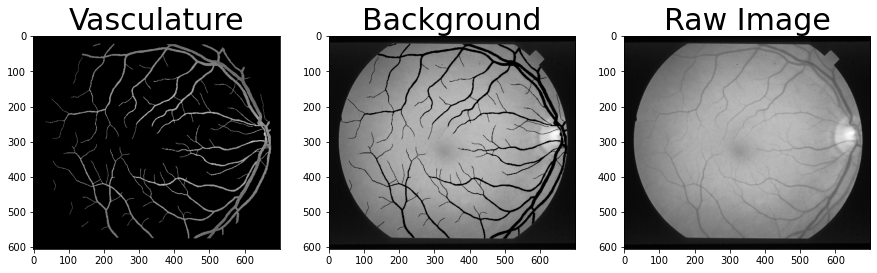

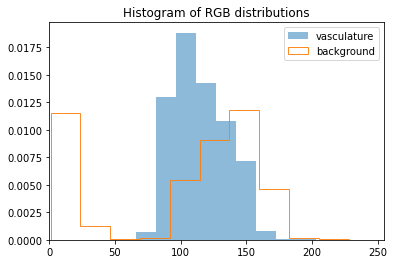

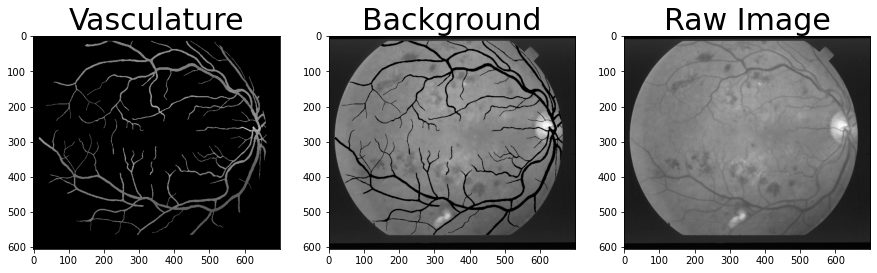

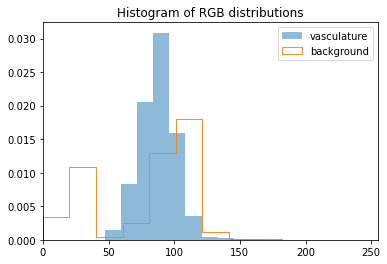

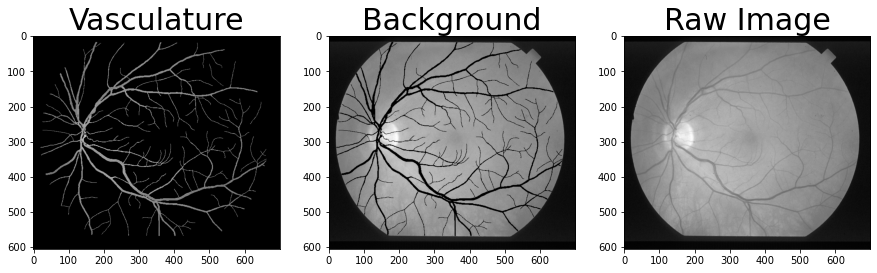

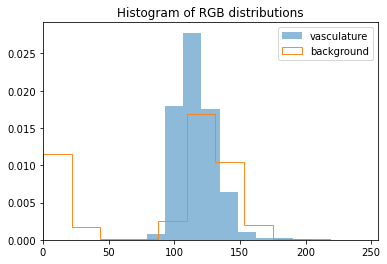

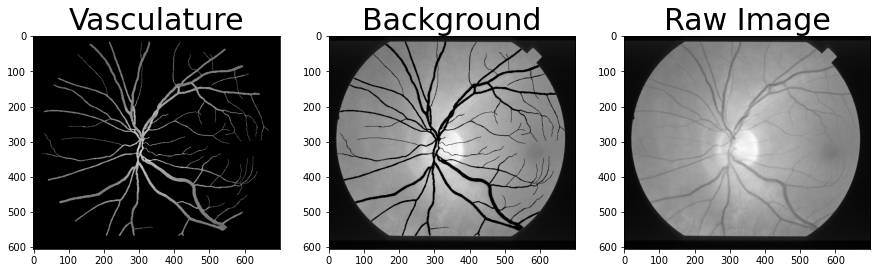

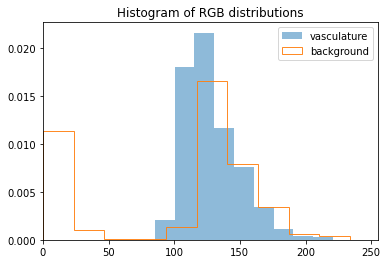

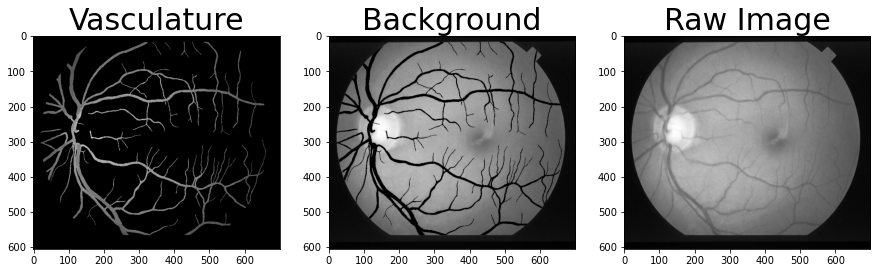

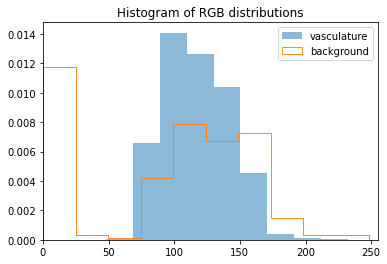

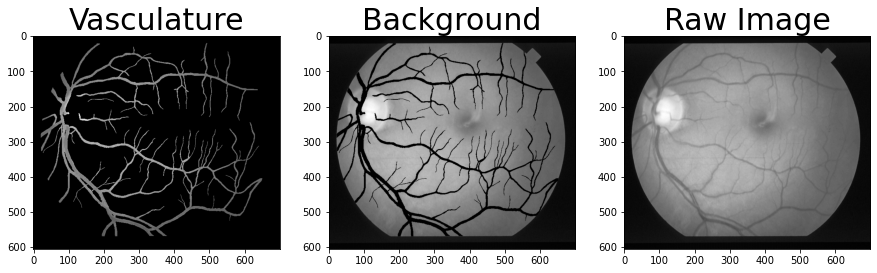

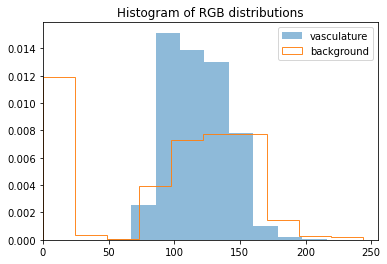

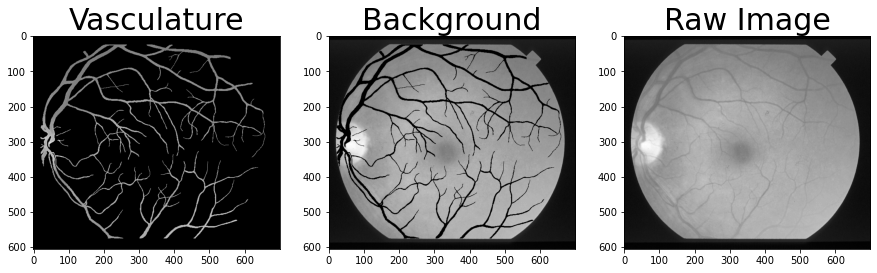

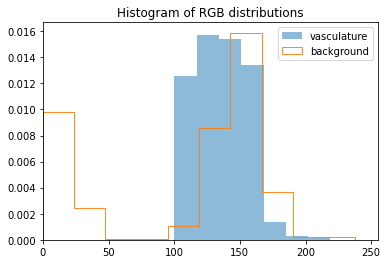

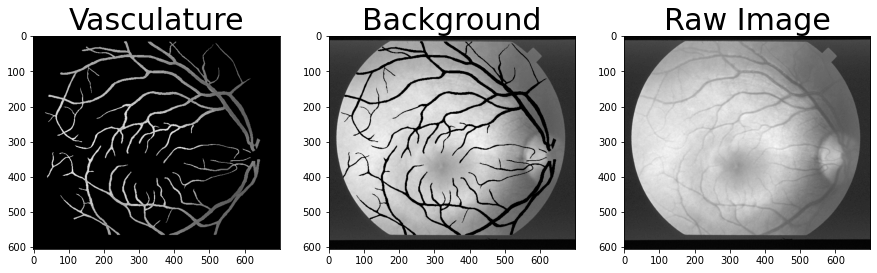

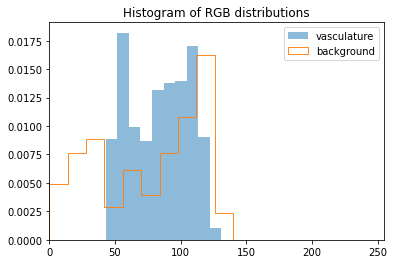

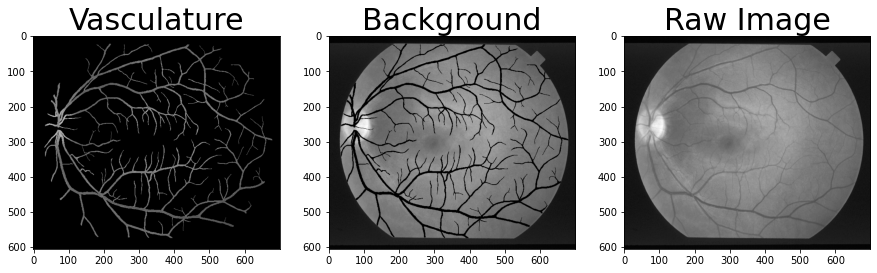

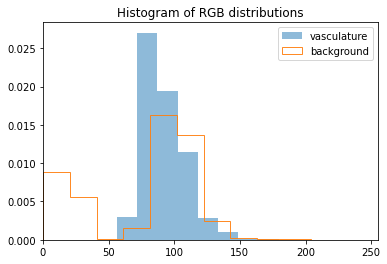

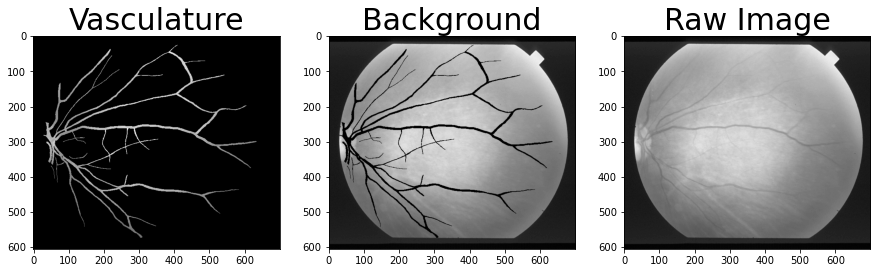

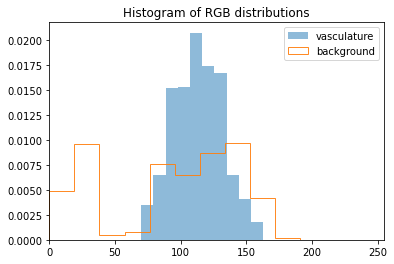

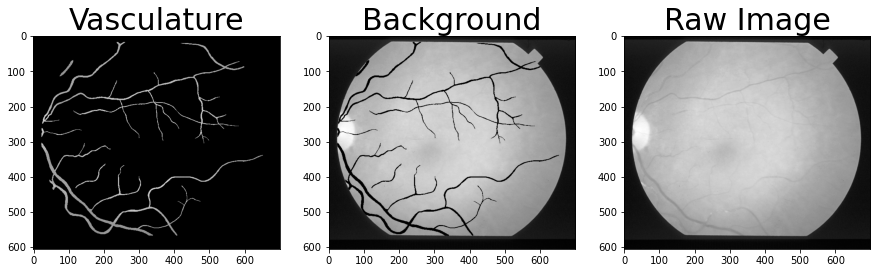

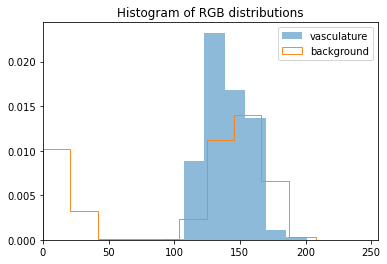

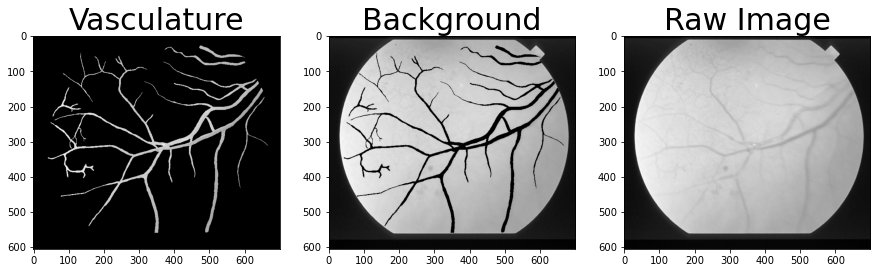

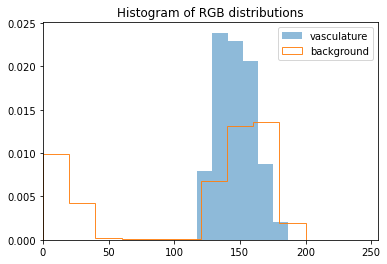

In [6]:
# COMPUTE THE P-VALUE FROM THE KS 2-SAMPLE TEST FOR ALL GRAY SCALE IMAGES AND SEGMENTATIONS (OPTIONALLY VIEW THE HISTOGRAMS)
stat_all_1_gray = [] # test statistics from using Grader1's segmentations
pval_all_1_gray = [] # p-value from using Grader1's segmentations
stat_all_2_gray = [] # test statistics from using Grader2's segmentations
pval_all_2_gray = [] # p-value from using Grader2's segmentations
for idx, img in enumerate(imlist_gray):
    # Using seg1 (from Grader1) as input...
    out1 = compute_kstest_img_seg(img,seg1[idx],visImages=True)
    # Using seg2 (from Grader2) as input...
    out2 = compute_kstest_img_seg(img,seg2[idx],visImages=False)
    # Collect all the test statistics and p-values inot a list
    stat_all_1_gray.append(out1[0])
    pval_all_1_gray.append(out1[1])
    stat_all_2_gray.append(out2[0])
    pval_all_2_gray.append(out2[1])

In [7]:
print("pval from Grader1's segmentations (for grayscale): ", pval_all_1_gray)
print("pval from Grader2's segmentations (for grayscale): ", pval_all_2_gray)

pval from Grader1's segmentations (for grayscale):  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
pval from Grader2's segmentations (for grayscale):  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]


## Observations from the data so far...
<li> All images and segmentations are the same size, namely [605 x 700 x 3], where 3 indicates the RGB color channels.
<li> All images are the same data type, namely uint8.
<li> There are 10 images from patients with eye diseases and 10 images from healthy patients.
<li> The KS Test seems to tell us that the intensity distributions between the background and the vasculature are all significantly different (using both sets of ground truth segmentations). This is encouraging as it suggests it’s possible to separate the vasculature from the noisy background.
    
    
    
    
    

## Segmentation of the vasculature: Apply classical image transformations that will isolate the vasculature from the noisy background. 
 
Since we only have 20 cases, it's not possible to rely on machine learning methods that require training and validation data in large quantities. Instead we can turn to classical computer vision techniques to manipulate the image in such a way that reduces the background noise to increase conrast between the vasculature and background. These techniques are very fast and should be able to give a good preliminary segmentation.

Working with gray scale images for ease...
1) We first determine a threshold for a mask that will segment the retina from the dark background at the periphery.

2) Next, we apply a Gaussian blur fliter to denoise the image and ensure that the vasculature stands out more clearly against the background. 

3) Next, we apply adaptive thresholding to determine a local threshold (rather than a global threshold), which is useful when the lighting across the image is not uniform. 

4) Finally, apply a morphological transformation (erosion with dilation for further noise removal) with a rectangular structiring element to select the neighborhood of pixels. 

### Metric: The DICE coefficient will be used as the metric for determining the segmentation performance. 
Other options include simple accuracy (number of pixels accurately assigned over the total number of pixels), but this metric is flawed, which is exacerbated when the segmentation of interest is sparse (like vasculature). DICE penalizes incorrect segmentation assignments and is widely used in segmentation tasks.

In [8]:
# APPLY THE SEGMENTATION FUNCTION TO THE GRAYSCALE RAW IMAGES 

seg_out = segment_vasculature(imlist_gray,40)

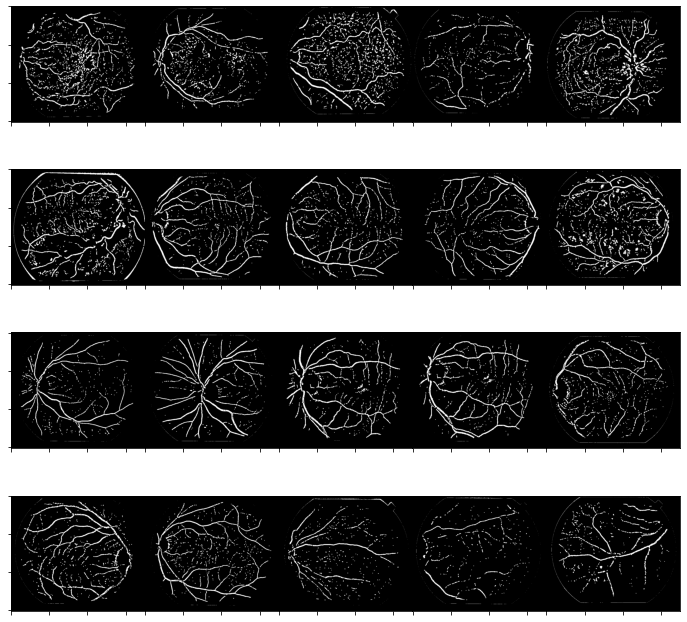

In [9]:
# VISUALIZE THE RESULTANT SEGMENTATIONS
plot_images_from_list(seg_out,nrow=4,ncol=5)

In [10]:
# COMPUTE THE DICE SCORE FOR EACH OF THE 20 CASES, USING GRADER1 AND GRADER2 segmentations

dice_dict = {"imgIDX":[],"DICE Grader1":[],"DICE Grader2":[]}
#loop through each segmentation
for idx,seg in enumerate(seg_out):
    seg_gt_1=seg1[idx] # Grader1 ground truth
    seg_gt_2=seg2[idx] # Grader2 ground truth
    dice_1_i = compute_DICE_score(seg_gt_1,seg) # get the dice using Grader1
    dice_2_i = compute_DICE_score(seg_gt_2,seg) # get the dice using Grader2
    
    # store the dice scores in the dice_dict dictionary
    dice_dict["imgIDX"].append(idx)
    dice_dict["DICE Grader1"].append(dice_1_i)
    dice_dict["DICE Grader2"].append(dice_2_i)

# save the results as a CSV in the homedir defined above!
dice_df = pd.DataFrame.from_dict(dice_dict)
dice_df.to_csv(f"{savedir}/dice_{datetime.datetime.now().timestamp()}.csv")


In [11]:
# print the maximum and minimum dice scores!
print("Grader1's maximum dice is ", dice_df["DICE Grader1"].max(axis=0))
print("Grader1's minimum dice is ", dice_df["DICE Grader1"].min(axis=0))
print("Grader1's mean dice is ", dice_df["DICE Grader1"].mean(axis=0))

print("Grader2's maximum dice is ", dice_df["DICE Grader2"].max(axis=0))
print("Grader2's minimum dice is ", dice_df["DICE Grader2"].min(axis=0))
print("Grader2's mean dice is ", dice_df["DICE Grader2"].mean(axis=0))

Grader1's maximum dice is  0.7488242087468827
Grader1's minimum dice is  0.45943243336436673
Grader1's mean dice is  0.6035515862920329
Grader2's maximum dice is  0.6558652317315147
Grader2's minimum dice is  0.4064065136459812
Grader2's mean dice is  0.533566291028402


# How good is the performance of the proposed model in terms of DICE score with the given hyperparameters?


The highest DICE score among both graders that we observe is 0.749, while the lowest is 0.406. Typically for medical applications, we like to see a DICE of 0.70 or above, which is similar to 70% or higher overlap between the segmentation output and the ground truth reference.  The mean scores of 0.604 and 0.533 for Graders 1 and 2, respectively, are lower than ideal. 

The human readers are better able to identify and segment minimscule vessels, whereas the proposed algorithm struggles to identify these small vessels from the noise. On visual inspection, the retina with artifacts of disease appear to occlude parts of the vasculature, inducing more failure in the proposed segmentations. 

There is opportunity for further hyperparameter optimization, like the selected thresholding and the size of the kernels in the image transformations. 

# What is the image quality of the data?

Because there are no reference images for quality assessment, we can use BRISQUE (Blind/Referenceless Image Spatial Quality Evaluator) as well as a blur score to get an idea of the quality. 

BRISQUE scores range from (0,100), with lower scores representing better perceptual quality. The default reference models for comparision, based on natural image scenes, were downloaded from github at https://github.com/opencv/opencv_contrib/tree/master/modules/quality/samples.


The blur score -- computed using the second derivate across the image and hence past rate of change across edges -- tells us whether there are sharp edges. Larger blur scores therefore indicate clearer images and less blur/smear across edges. 


In [12]:
qual_metrics = {"imgIDX":[],"BRISQUE":[],"Blur":[]}

#loop through each gray scale image
for idx,img in enumerate(imlist_gray):
    blurScore = cv2.Laplacian(img, cv2.CV_64F).var()
    brisque = cv2.quality.QualityBRISQUE_compute(img, f"{codedir}brisque_model_live.yml", f"{codedir}brisque_range_live.yml")
    qual_metrics["imgIDX"].append(idx)
    qual_metrics["BRISQUE"].append(brisque[0])
    qual_metrics["Blur"].append(blurScore)

qual_metrics_df = pd.DataFrame.from_dict(qual_metrics)
qual_metrics_df.to_csv(f"{savedir}/qualmetrics_{datetime.datetime.now().timestamp()}.csv")


# Is the DICE score influenced by the presence of disease as well as the image quality?

For determining significance of DICE when stratified by diseased vs. healthy retinas, we can apply the Wilcoxon Rank Sum test. This is appropriate given the small sample size in each category (N=10 in diseased and healthy, respectively).

Please see the R script for all the statistical analyses: ~/Code/stat_analysis_ophthalmicimages.R!

## Are deep learning approaches feasible?


Supervised deep learning algorithms for segmentation are limited by the availability of high quality annotated ground truth data for training. 

If we have thousands of annotated examples for training, validation, and testing, then it would certainly be feasible to apply a simple architecture, like a U-Net to this segmentation task. Considerations for preprocessing would include normalization as well as resampling and resizing to ensure all images are the same size and resolution. We would also need to ensure that there are no class imbalances between diseased and healthy eyes so taht the network can "see" ample examples of all possible cases. 

There are also ample pre-trained networks in the literature that could be fine tuned for this specific task and thus reduce the data requirement; however, one limitation in using pretrained models is the need to preprocess the data for fine tuning in a way that the pretrained model expects for input. 

The Medical SAM (Segment Anything Model) is a recent work that shows a lot of promise for various segmentation tasks in medical imaging. The authors have published their code, making it possible to reproduce it!


# OLD APPROACH: Attempted k-means clustering on the RGB space, which understandably failed 

def segment_kmeans(features,nclust):
    # INPUTS:
    # - features: n_observations x n_features matrix (for this task, each row is a pixel, and each column
    # is a feature, namely: R, G, B, row, column. The first column is the image ID.)
    # - nclust: number of desired clusters for k-means
    # OUTPUTS: list of segmentation maps for each image ID in the feature matrix. 
    # Each segmentation map is 605 x 700, and we expect 20 of them.
    
    # run k-means on the features matrix, excluding the first column because it's the image ID, not a feature.
    # random_state=0 is a seed so that we can reproduce the results.
    kmeans_out = KMeans(n_clusters=nclust, random_state=0,n_init='auto').fit(features[:,1:4])
    labels = kmeans_out.labels_
    
    seg_out = []
    count = Counter(features[:,0]) #unique image IDs and their corresponding number of samples/pixels per ID.
    num_ids = len(count.keys()) # number of unique image IDs
    for i in range(0,num_ids):
        # we know the shape of each image as 605x700, so we can use it here
        seg_i = np.uint8(labels[i*count[i]:(i+1)*count[i]].reshape(605,700))
        seg_out.append(seg_i)
        
    return seg_out,kmeans_out

### CREATE THE FEATURE MATRIX, NORMALIZING R,G,B VALUES ACROSS ALL PIXELS IN THE DATASET OF 20 PATIENTS

num_pix = 605*700
num_cases = len(imlist)
features = np.zeros((num_pix*num_cases, 6)) # initialize the feature array as zeros
coor = np.indices((605,700)) # get the coordinates of the 605 x 700 images
y=coor[0] # y or row coordinates
x=coor[1] # x or column coordinates
for i in range(0,num_cases):
    img_temp = imlist[i] # get the image at index i in the list of raw images, imlist
    img_r = img_temp[:,:,0].ravel() #vectorize the red channel
    img_g = img_temp[:,:,1].ravel() #vectorize the green channel
    img_b = img_temp[:,:,2].ravel() #vectorize the blue channel
    features[i*num_pix:(i+1)*num_pix,0]=i # this is the image ID for our purposes (or case index)
    features[i*num_pix:(i+1)*num_pix,1]=img_r
    features[i*num_pix:(i+1)*num_pix,2]=img_g
    features[i*num_pix:(i+1)*num_pix,3]=img_b
    features[i*num_pix:(i+1)*num_pix,4]=y.ravel()
    features[i*num_pix:(i+1)*num_pix,5]=x.ravel()
    
### APPLY K-MEANS CLUSTERING ON THE FEATURE SPACE
nclust = 2
clust_result = segment_kmeans(features,nclust)

### VISUALIZE K-MEANS RESULTS
seg_guess = clust_result[0]
plt.imshow(seg_guess[0])
plt.colorbar()